# Práctica 4: Procesamiento del Lenguaje Natural

__Fecha de entrega: 14 de mayo de 2024__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

* Autores: Lucía Alonso Mozo y Javier Amado Lázaro

* Grupo: K

In [1]:
RANDOM_STATE = 1234

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


# 1) Carga del conjunto de datos

El fichero `spam.csv` contiene mensajes SMS etiquetados como spam or ham (legítimo).

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 60% para entrenamiento, 20% para validación y el 20% restante para test. Comprueba que la distribución de los ejemplos en las particiones es similar. 

In [3]:
# Vamos a ver un ejemplo con un conjunto de opiniones (positivas o negativas) de restaurantes del recomendador Yelp

import pandas as pd

yelp_file = './spam.csv'

df=pd.read_csv(yelp_file, delimiter=',', names=['etiqueta', 'sentencia', 'v3', 'v4', 'v5'], encoding = 'cp1252')

df = df[df['v3'].isna()] # eliminamos las que no tienen v3 a nulo

# Eliminar las últimas tres columnas
df = df.iloc[:, :-3]

# Eliminamos la primera fila
df = df.drop(df.index[0])

# Reseteamos el index
df = df.dropna().reset_index(drop = True) #eliminamos las filas con valores nulos.

df

,etiqueta,sentencia
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5517,spam,This is the 2nd time we have tried 2 contact u...
5518,ham,Will Ì_ b going to esplanade fr home?
5519,ham,"Pity, * was in mood for that. So...any other s..."
5520,ham,The guy did some bitching but I acted like i'd...


### Mostramos un ejemplo de cada clase
A continuación mostramos un ejemplo de sentencia legítima y otro de spam.

In [4]:
df.iloc[[0]]

,etiqueta,sentencia
0,ham,"Go until jurong point, crazy.. Available only ..."


In [5]:
df.iloc[[2]]

,etiqueta,sentencia
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


### Palabras que aparecen más

In [6]:
from collections import Counter

def palabras_mas_frecuentes(texto):
    # Tokenizar cada frase y agregar las palabras a la lista de palabras
    lista_palabras = []

    for frase in texto:
        palabras = frase.split()
        lista_palabras.extend(palabras)

    # Contar la frecuencia de cada palabra
    frecuencia_palabras = Counter(lista_palabras)
    
    # Encontrar las 5 palabras más comunes
    palabras_mas_comunes = frecuencia_palabras.most_common(5)

    return palabras_mas_comunes


In [7]:
resultado = palabras_mas_frecuentes(df['sentencia'].tolist())
print("Las 5 palabras más frecuentes son:")
for palabra, frecuencia in resultado:
    print(f"- {palabra}: {frecuencia} veces")

Las 5 palabras más frecuentes son:
- to: 2119 veces
- you: 1613 veces
- I: 1461 veces
- a: 1306 veces
- the: 1184 veces


Analizando los datos, obtenemos que las cinco palabras que más aparecen son las que se reflejan en la celda anterior. Se puede ver que la palabra 'to' es la más común. Nos damos cuenta de que esta clasificación no nos aporta mucho significado, ya que por ejemplo, se están evaluando como palabras diferentes las que son iguales pero empiezan por mayúscula en vez de por minúscula. Por eso, vemos claramente que debemos normalizar el texto, convirtiéndolo todo a minúsculas y eliminando las palabras sin significado ('stop words').

#### Normalización 

Usamos las stopwords por defecto del inglés. De las palabras más mostradas anteriormente, nos elimina todas.

In [8]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [9]:
norm_corpus = normalize_corpus(df['sentencia'])
norm_corpus
df['sentenciaN'] = norm_corpus
df = df.drop(['sentencia'], axis = 1)

resultado = palabras_mas_frecuentes(df['sentenciaN'].tolist())
print("Las 5 palabras más frecuentes son:")
for palabra, frecuencia in resultado:
    print(f"- {palabra}: {frecuencia} veces")

Las 5 palabras más frecuentes son:
- u: 1127 veces
- call: 579 veces
- im: 473 veces
- get: 384 veces
- ur: 377 veces


Ahora, la palabra que más se usa es 'u' con una frecuencia de 1127. Suponemos que 'u' se refiere a un coloquialismo de 'you', y consideramos que es una palabra que no aporta especial significado y que por tanto, podríamos considerarla como stop word para coger palabras que puedan aportar más significado. Sin embargo, no está definida por defecto y por tanto lo dejaremos asi. Las siguientes palabras con más frecuencia en los correos son 'call', 'im', 'get', y 'ur', que ninguna aporta tampoco demasiado significado ni información. 

### Partición de datos

Partimos los datos en un 60% de entrenamiento, 20% de validación y 20% de test. Para ello, realizamos una primera partición de 40% test y 60% train, y a continuación dividimos la parte del test a la mitad para quedarnos con un 20% de test y otro 20% de validación.

In [10]:
from sklearn.model_selection import train_test_split

# Partimos el conjunto de datos en entrenamiento (70%) y test (30%)
X_train, X_test_val, y_train, y_test_val = train_test_split(df.drop(['etiqueta'], axis = 1), df['etiqueta'], test_size=0.40, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.50, random_state=RANDOM_STATE)

In [11]:
df.describe(include=['object']).transpose()

,count,unique,top,freq
etiqueta,5522,2,ham,4780
sentenciaN,5522,5027,sorry ill call later,30


Para estudiar que ambos conjuntos presentan una relación vemos porcentajes en cuanto a cuántos correos de cada tipo presentan.

In [12]:
from collections import Counter

def porcentaje_clases(columna):
    # Contar la frecuencia de cada clase
    conteo_clases = Counter(columna)
    
    # Calcular el total de instancias
    total_instancias = sum(conteo_clases.values())
    
    # Calcular el porcentaje de cada clase
    porcentaje_spam = (conteo_clases['spam'] / total_instancias) * 100
    porcentaje_ham = (conteo_clases['ham'] / total_instancias) * 100
    
    return porcentaje_spam, porcentaje_ham

##### Porcentajes

In [13]:
porcentaje_spam, porcentaje_ham = porcentaje_clases(y_train)
print("Porcentaje de 'spam' en el entrenamiento: {:.2f}%".format(porcentaje_spam))
print("Porcentaje de 'ham' en el entrenamiento: {:.2f}%".format(porcentaje_ham))

porcentaje_spam, porcentaje_ham = porcentaje_clases(y_test)
print("Porcentaje de 'spam' en el test: {:.2f}%".format(porcentaje_spam))
print("Porcentaje de 'ham' en el test: {:.2f}%".format(porcentaje_ham))

porcentaje_spam, porcentaje_ham = porcentaje_clases(y_val)
print("Porcentaje de 'spam' en la validación: {:.2f}%".format(porcentaje_spam))
print("Porcentaje de 'ham' en la validación: {:.2f}%".format(porcentaje_ham))

Porcentaje de 'spam' en el entrenamiento: 13.64%
Porcentaje de 'ham' en el entrenamiento: 86.36%
Porcentaje de 'spam' en el test: 14.04%
Porcentaje de 'ham' en el test: 85.96%
Porcentaje de 'spam' en la validación: 12.22%
Porcentaje de 'ham' en la validación: 87.78%


En el conjunto de entrenamiento, el 13.64% de las instancias están etiquetadas como 'spam', mientras que el 86.36% están etiquetadas como 'ham'. Esto sugiere que el conjunto de entrenamiento contiene una mayoría significativa de instancias de la clase 'ham', con una proporción relativamente menor de instancias de la clase 'spam'.

En el conjunto de prueba, el porcentaje de instancias 'spam' es ligeramente mayor, con un 14.04%, mientras que el porcentaje de instancias 'ham' es ligeramente menor, con un 85.96%. Esto indica una distribución de clases similar al conjunto de entrenamiento, pero con una ligera variación.

Finalmente, en el conjunto de validación, el 12.22% de las instancias son 'spam', mientras que el 87.78% son 'ham'. Esta distribución es similar a la del conjunto de entrenamiento, aunque con un porcentaje ligeramente menor de instancias 'spam' y un porcentaje ligeramente mayor de instancias 'ham'.

En resumen, los datos sugieren que los conjuntos de entrenamiento, prueba y validación tienen una distribución de clases bastante equilibrada, con una ligera variación entre ellos.

# 2) Representación como bolsa de palabras

Elige justificadamente una representación de bolsa de palabras y aplícala.
Muestra un ejemplo antes y después de aplicar la representación. Explica los cambios.

Hemos decidido usar la bolsa de palabras creada obteniendo la frecuencia de los términos de los documentos con un diccionario elaborado previamente. El diccionario que usaremos serán los propios correos que transformaremos a diccionario.

En primer lugar, vamos a justificar nuestra elección de TF-IDF para generar la bolsa de palabras.

Sabemos que TF-IDF asigna pesos a cada término en función de su frecuencia en un documento específico y su frecuencia en el corpus completo de documentos. Esto ayuda a destacar términos que son importantes para un documento en particular pero poco comunes en el corpus general.
Además, los términos que son comunes en muchos documentos tienden a tener una alta frecuencia en un documento pero son poco informativos en términos de su capacidad para distinguir entre documentos. Sin embargo, con TF-IDF reducimos el peso de estos términos comunes al ponderarlos inversamente proporcional a su frecuencia en el corpus completo.

A su vez, TF-IDF resalta los términos que son únicos o característicos de un documento en particular. Esto puede ser útil para tareas como la clasificación de documentos o la recuperación de información, donde es importante identificar los términos que son más descriptivos de un documento.
Al asignar pesos más altos a los términos que son más relevantes para un documento en particular, TF-IDF ayuda a mejorar la relevancia de la información recuperada en tareas como la búsqueda de información o la recuperación de documentos.


Como hemos podido comprobar en los notebooks proporcionados por el profesor, al usar TF-IDF tenemos dos opciones: usar un diccionario obtenido mediante el conjunto de datos de entrenamiento o elaborar nuestro propio diccionario. Vamos a reflejar una serie de ventajas e incovenientes que presentan estas dos opciones. 

Al generar nuestro propio diccionario, tenemos control total sobre qué términos se incluyen y cómo se representan. Esto puede ser útil para enfocarse en términos específicos que consideramos importantes para la clasificación de mensajes spam o ham. Además, utilizar un diccionario propio garantiza consistencia en el procesamiento de texto a lo largo del tiempo y en diferentes conjuntos de datos. Esto puede ser beneficioso para garantizar la reproducibilidad y la coherencia en el análisis de texto. Sin embargo, puede presentar algunas desventajas, como puede ser la introducción de sesgos en el análisis si el diccionario no refleja completamente la variabilidad y diversidad del lenguaje natural en el conjunto de datos.
A su vez, se pueden perder términos importantes o relevantes que no se hayan incluido en el diccionario elaborado previamente.

Por otro lado, si utilizamos el diccionario inferido por el entrenamiento, se asegura la inclusión de estos términos específicos y relevantes, lo que puede mejorar la precisión del modelo. Los mensajes spam y ham pueden contener términos que son únicos para ese conjunto de datos y que pueden no estar presentes en un diccionario general elaborado previamente. Sin embargo, presenta algunas desventajas importantes como la presencia de términos irrelevantes o ruidosos que pueden afectar negativamente el rendimiento del modelo si no se realiza un filtrado adecuado.

Debido a la gran cantidad de ruido que genera usar un diccionario inferido por el entrenamiento, nos decantamos por la opción de utilizar un diccionario generado previamente. De esta manera, tendremos un control completo sobre qué términos se incluyen y cuáles se excluyen. Así lograremos paliar la inclusión de términos irrelevantes o ruidosos que pueden ser capturados si se genera el diccionario a partir de los datos de entrenamiento.
A su vez, al limitar el diccionario a un conjunto específico de términos, se puede reducir la complejidad computacional y mejorar la eficiencia en el procesamiento de texto.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

lista_palabras = []

for frase in df['sentenciaN'].tolist():
    palabras = frase.split()
    lista_palabras.extend(palabras)

diccionario = list(set(lista_palabras)) # lo convertimos en lista sin repetidos
diccionario.sort() #lo ordenamos alfabeticamente

vectorizer = CountVectorizer(vocabulary=diccionario)

In [15]:
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))
print(feature_names[:100])

8323
['aa' 'aah' 'aaniye' 'aaooooright' 'aathilove' 'aathiwhere' 'ab' 'abbey'
 'abdomen' 'abeg' 'aberdeen' 'abi' 'ability' 'abiola' 'abj' 'able'
 'abnormally' 'aboutas' 'abroad' 'absence' 'absolutely' 'abstract' 'abt'
 'abta' 'aburo' 'abuse' 'abusers' 'ac' 'academic' 'acc' 'accent'
 'accenture' 'accept' 'access' 'accessible' 'accidant' 'accident'
 'accidentally' 'accommodation' 'accommodationvouchers' 'accomodate'
 'accomodations' 'accordin' 'accordingly' 'accordinglyor' 'account'
 'accounting' 'accounts' 'accumulation' 'achanammarakheshqatar' 'ache'
 'achieve' 'acid' 'acknowledgement' 'aclpm' 'acnt' 'acoentry' 'across'
 'acsmsrewards' 'act' 'acted' 'actin' 'acting' 'action' 'activ' 'activate'
 'active' 'activities' 'actor' 'actual' 'actually' 'acwicmbcktzr' 'ad'
 'adam' 'add' 'addamsfa' 'added' 'addicted' 'addie' 'adding' 'address'
 'addressull' 'adds' 'adewale' 'adi' 'adjustable' 'admin' 'administrator'
 'admirer' 'admission' 'admit' 'admiti' 'adore' 'adoring' 'adp' 'adress'
 'adrian

In [16]:
train_vector_data = vectorizer.fit_transform(X_train['sentenciaN'])
print(train_vector_data[10])

  (0, 4100)	1
  (0, 4684)	1


In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

# Calculamos el valor TF-IDF 

tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

print(train_preprocessed[10])

  (0, 4684)	0.5313417323253502
  (0, 4100)	0.8471575789010543


In [18]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [19]:
print("Antes: " + np.array(X_train)[10])
write_terms(feature_names, None, train_vector_data, 10)
print(train_preprocessed[10])

print("Antes: " + np.array(X_train)[1000])
write_terms(feature_names, None, train_vector_data, 1000)
print(train_preprocessed[1000])

['Antes: lover need']
Mensaje 10 vectorizado: ['lover' 'need'] 

  (0, 4684)	0.5313417323253502
  (0, 4100)	0.8471575789010543
['Antes: get garden ready summer free selection summer bulbs seeds worth scotsman saturday stop go notxtcouk']
Mensaje 1000 vectorizado: ['bulbs' 'free' 'garden' 'get' 'go' 'notxtcouk' 'ready' 'saturday'
 'scotsman' 'seeds' 'selection' 'stop' 'summer' 'worth'] 

  (0, 8083)	0.23027384642164397
  (0, 6909)	0.5300004894895071
  (0, 6790)	0.16089851086966891
  (0, 6196)	0.26500024474475353
  (0, 6180)	0.28879471231668014
  (0, 6142)	0.28879471231668014
  (0, 6107)	0.23716250223634824
  (0, 5743)	0.20074471944150268
  (0, 4824)	0.28879471231668014
  (0, 2789)	0.13731146483737208
  (0, 2739)	0.1288697356232848
  (0, 2692)	0.28879471231668014
  (0, 2584)	0.1447124907662903
  (0, 919)	0.28879471231668014


In [20]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(X_test['sentenciaN'])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed=tfidfer.transform(test_vector_data)

In [21]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
val_vector_data=vectorizer.transform(X_val['sentenciaN'])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
val_preprocessed=tfidfer.transform(val_vector_data)

# 3) Aplica 3 algoritmos de aprendizaje automático para resolver la tarea

Justifica porqué los has elegido.
Ajusta los modelos respecto a un hiperparámetro que consideres oportuno. Justifica tu elección.
Explica los resultados obtenidos.

### Árbol de decisión

In [22]:
from sklearn import tree
import numpy as np

# Creamos el clasificador con los valores por defecto
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_preprocessed, y_train)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_val_predictions = tree_classifier.predict(val_preprocessed)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en validación:", np.mean(tree_val_predictions == y_val))

Árbol, porcentaje de aciertos en entrenamiento: 1.0
Árbol, porcentaje de aciertos en validación: 0.9475113122171945


Una precisión de 1 en los datos de entrenamiento y una precisión ligeramente más baja en los datos de validación (0.94 en este caso) podría indicar que el modelo está sobreajustando los datos de entrenamiento. Esto significa que el modelo puede estar memorizando los datos de entrenamiento en lugar de generalizar para datos nuevos. A pesar de esto, una precisión de 0.94 en los datos de validación todavía indica una buena capacidad de generalización del modelo. Esto significa que el modelo ha aprendido patrones útiles de los datos de entrenamiento y es capaz de aplicar estos patrones a nuevos datos con un alto grado de precisión. 

A continuación, para mejorar la precisión en los datos de validación, intentaremos ajustar uno de los hiperparámetros del árbol de decisión, como es la profundidad máxima del árbol.

In [23]:
train_accuracy = []
val_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(1, 20)
for md in max_depths:
    tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    tree_classifier.fit(train_preprocessed, y_train)

    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_val_predictions = tree_classifier.predict(val_preprocessed)    

    train_accuracy.append(np.mean(tree_train_predictions == y_train))
    val_accuracy.append(np.mean(tree_val_predictions == y_val))

train_accuracy, val_accuracy

([0.891035315424087,
  0.923332327195895,
  0.9275581044370661,
  0.9399335949290674,
  0.9456685783277996,
  0.9586477512828252,
  0.9655900996076064,
  0.9683066706912165,
  0.9746453365529731,
  0.9779655900996076,
  0.9809840024147298,
  0.9837005734983398,
  0.9855116208874132,
  0.9873226682764865,
  0.9873226682764865,
  0.9885300332025355,
  0.9894355568970722,
  0.9903410805916089,
  0.9909447630546333],
 [0.8823529411764706,
  0.9375565610859729,
  0.9330316742081448,
  0.9375565610859729,
  0.9429864253393665,
  0.9375565610859729,
  0.9420814479638009,
  0.9375565610859729,
  0.9393665158371041,
  0.9457013574660633,
  0.9475113122171945,
  0.9411764705882353,
  0.9429864253393665,
  0.9529411764705882,
  0.9520361990950226,
  0.9475113122171945,
  0.9484162895927601,
  0.9484162895927601,
  0.9502262443438914])

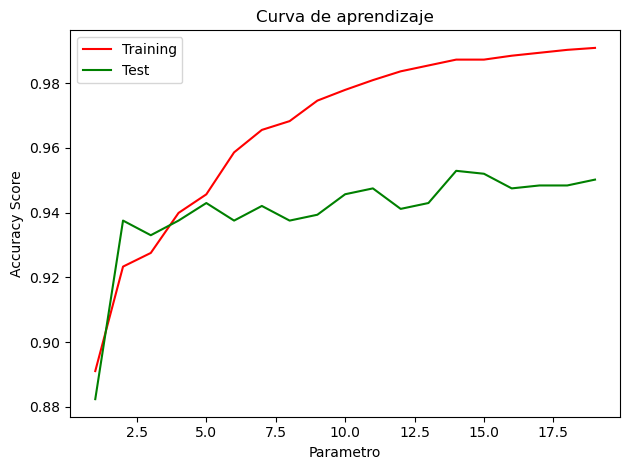

In [24]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, val_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Una vez estudiados los resultados obtenidos, podemos observar que la profundidad óptima del árbol de decisión en un rango de 1 a 20 es 14, ya que alcanza el porcentaje de validación más alto: 0.9520361990950226. De esta manera conseguimos encontrar un equilibrio entre la capacidad predictiva del modelo, la generalización, la interpretación y el costo computacional, lo que conduce a un modelo más eficaz y útil en la práctica.

### k Vecinos Más Cercanos (k-NN)

In [25]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, y_train)

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_val_predictions = knn_classifier.predict(val_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == y_train))
print("k-NN, porcentaje de aciertos en validacion:", np.mean(knn_val_predictions == y_val))

k-NN, porcentaje de aciertos en entrenamiento: 0.9169936613341383
k-NN, porcentaje de aciertos en validacion: 0.9149321266968325


La tasa de aciertos cercana al 0.9149321266968325 en los datos de validación indica que el modelo kNN generaliza bien para datos nuevos que no ha visto durante el entrenamiento. Esto es positivo, ya que demuestra que el modelo es capaz de hacer predicciones precisas en datos no vistos.

Por otro lado, la pequeña diferencia entre la tasa de aciertos en los conjuntos de entrenamiento y validación (0.9169936613341383 y 0.9149321266968325 respectivamente) sugiere que el modelo no está sufriendo de sobreajuste significativo. Esto indica que el modelo kNN está aprendiendo patrones generales de los datos que se aplican bien a datos nuevos, lo que es deseable en términos de generalización del modelo. Es decir, podemos afirmar que el modelo es consistentemente preciso en diferentes conjuntos de datos.

Aunque una tasa de aciertos del 0.914 es bastante buena, siempre hay margen para mejorar. Se pueden explorar diferentes técnicas para mejorar el rendimiento del modelo kNN. La que vamos a elegir nosotros es la optimización del hiperparámetro k.



In [26]:
# Medias y desviaciones típicas de accuracy para distintos valores de k
accuracy_mean = []
accuracy_std = []

k_values = range(1,20)
for k in k_values:
    # Entrenar y validar
    knn_classifier = neighbors.KNeighborsClassifier(k, weights='distance')
    knn_classifier.fit(train_preprocessed, y_train)

    knn_train_predictions = knn_classifier.predict(train_preprocessed)
    knn_val_predictions = knn_classifier.predict(val_preprocessed)  

    accuracy_mean.append(np.mean(knn_val_predictions == y_val))
    accuracy_std.append(np.std(knn_val_predictions == y_val))

accuracy_mean, accuracy_std

([0.9457013574660633,
  0.9457013574660633,
  0.9393665158371041,
  0.9375565610859729,
  0.9276018099547512,
  0.9248868778280543,
  0.9212669683257918,
  0.9194570135746606,
  0.9194570135746606,
  0.9321266968325792,
  0.9357466063348416,
  0.9438914027149321,
  0.9447963800904977,
  0.9475113122171945,
  0.9466063348416289,
  0.9475113122171945,
  0.9502262443438914,
  0.9493212669683257,
  0.951131221719457],
 [0.2266060457112926,
  0.2266060457112926,
  0.2386567928242642,
  0.24195920286407235,
  0.2591460825932371,
  0.2635737867268444,
  0.2693216318783107,
  0.27213197857478444,
  0.27213197857478444,
  0.2515283639762406,
  0.24520378273523544,
  0.23013131598235376,
  0.2283772761427666,
  0.22301037069527643,
  0.22481721837823454,
  0.22301037069527643,
  0.21747719168684013,
  0.21934082850663827,
  0.21559364737837272])

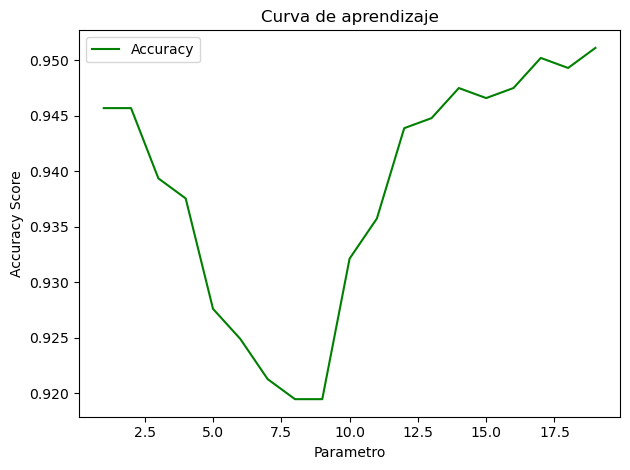

In [27]:
# Dibujamos la línea con la accuracy (exactitud) en el test
plt.plot(k_values, accuracy_mean, color="g", label="Accuracy")

# Dibujamos la banda de la desviación típica
#lower_limit = np.array(accuracy_mean) - np.array(accuracy_std)
#upper_limit = np.array(accuracy_mean) + np.array(accuracy_std)
#plt.fill_between(k_values, lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

El mejor valor del parámetro lo obtenemos para k = 20.

Una vez estudiados los resultados obtenidos, podemos concluir que el valor óptimo para el hiperparámetro k es k = 20. Por tanto, esto contribuirá a la maximización de la capacidad del modelo para generalizar a nuevos datos, así como la reducción del riesgo de sobreajuste.

A modo de conclusión, podemos afirmar que ajustar el hiperparámetro k al valor óptimo en el algoritmo kNN puede mejorar la capacidad de generalización, reducir el impacto del ruido, aumentar la robustez del modelo y reducir el riesgo de sobreajuste y subajuste, lo que conduce a un modelo más eficaz y confiable.

### Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, y_train)

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_val_predictions = mnb_classifier.predict(val_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en validacion:", np.mean(mnb_val_predictions == y_val))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9661937820706309
Multinomial Naive Bayes, porcentaje de aciertos en validacion: 0.967420814479638


Una tasa de acierto cercana al 0.9661937820706309 en los datos de validación indica que el modelo Naive Bayes está haciendo predicciones precisas en un conjunto de datos que no ha visto durante el entrenamiento. Esto es positivo y sugiere que el modelo generaliza bien para datos nuevos, lo que es una indicación de su capacidad para capturar patrones en los datos.

Por otro lado, la pequeña diferencia entre la tasa de acierto en los conjuntos de entrenamiento y validación (0.9661937820706309 y 0.967420814479638, respectivamente) sugiere que el modelo no está sufriendo un sobreajuste significativo. Esto indica que el modelo Naive Bayes está aprendiendo patrones generales de los datos que se aplican bien a datos nuevos, lo que es deseable en términos de generalización del modelo. 

A su vez, la tasa de acierto alta en ambos conjuntos de datos sugiere que el modelo Naive Bayes es robusto y está capturando efectivamente la estructura subyacente de los datos. Esto significa que el modelo está haciendo un buen trabajo al clasificar las instancias en ambas configuraciones, lo que indica su capacidad para realizar predicciones precisas en diferentes conjuntos de datos.

Por tanto, podemos afirmar que el modelo presenta gran estabilidad.

Sin embargo, siempre es importante seguir evaluando y ajustando el modelo según sea necesario para asegurar un rendimiento óptimo en diferentes conjuntos de datos y escenarios. Para ello, vamos a calcular cuál es el valor óptimo para alpha.

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
import numpy as np

accuracy_mean = []
accuracy_std = []

# Entrenar y validar distintas configuraciones
regul_param_range = np.arange(0.1, 2.1, step=0.2) # [0.5, 0.75,  ..., 2]
for regul_param in regul_param_range:
    # Aumentamos el parámetro max_iter hasta que converja
    mnb_classifier = MultinomialNB(alpha=regul_param)

    mnb_classifier.fit(train_preprocessed, y_train)

    mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
    mnb_val_predictions = mnb_classifier.predict(val_preprocessed)

   # accuracy_mean.append(np.mean(mnb_train_predictions == y_train))
    accuracy_mean.append(np.mean(mnb_val_predictions == y_val))
    accuracy_std.append(np.std(mnb_val_predictions == y_val))

accuracy_mean, accuracy_std

([0.9601809954751132,
  0.9710407239819004,
  0.9755656108597285,
  0.9737556561085973,
  0.967420814479638,
  0.9638009049773756,
  0.9583710407239819,
  0.9520361990950226,
  0.9429864253393665,
  0.9393665158371041],
 [0.1955337602654179,
  0.1676920879189208,
  0.15439349004285535,
  0.15986112193123286,
  0.17753248207354005,
  0.18678522570633752,
  0.19973980330823832,
  0.21368966916471432,
  0.23186855536068243,
  0.23865679282426422])

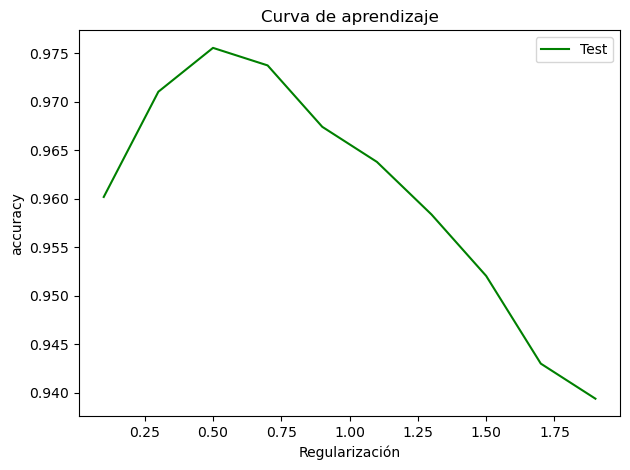

In [30]:
import matplotlib.pyplot as plt

# Dibujamos la línea de la exactitud media en las partes de test
plt.plot(regul_param_range, accuracy_mean, color="g", label="Test")

# Dibujamos la banda de la desviación típica
#lower_limit = np.array(accuracy_mean) - np.array(accuracy_std)
#upper_limit = np.array(accuracy_mean) + np.array(accuracy_std)
#plt.fill_between(regul_param_range, lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Regularización"), plt.ylabel("accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Tras realizar una serie de algoritmos y estudiar los resultados obtenidos, podemos afirmar que el valor óptimo para el hiperparámetro alpha es alpha = 0.5. A partir de esto, encontrar el valor óptimo de alpha puede mejorar el rendimiento del modelo al garantizar un suavizado adecuado y evitar problemas como la probabilidad cero o el sobreajuste, así como mejorar la capacidad del modelo para generalizar a nuevos datos.

En resumen, encontrar el valor óptimo del hiperparámetro alpha en el algoritmo Naive Bayes puede mejorar el rendimiento del modelo, su capacidad de generalización y su robustez, lo que resulta en predicciones más precisas y confiables en gran variedad de situaciones.

# 4) Construye redes neuronales con Keras con distintas maneras de usar word embeddings

Justifica tus decisiones y explica los resultados obtenidos.

### Sin word embeddings preentrenados

Debemos saber que al aplicar word embeddings sin embeddings pre-entrenados, se pueden obtener resultados que varían dependiendo de varios factores, incluyendo el tamaño y la calidad del conjunto de datos de entrenamiento, la complejidad de la tarea de NLP y la capacidad del modelo para capturar relaciones semánticas entre palabras durante el entrenamiento.

#### Datos de entrenamiento

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

max_words = 1500
max_comment_length = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train.sentenciaN)

sequences_train = tokenizer.texts_to_sequences(X_train.sentenciaN)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_words = len(word_index)

data_train = pad_sequences(sequences_train, maxlen=max_comment_length)

Found 6225 unique tokens.


Debemos convertir la columna de etiqueta con valores como spam o ham a enteros.

In [49]:
Y_train_adap = pd.DataFrame(y_train, columns=["etiqueta"])['etiqueta']
Y_train_adap.replace(['spam', 'ham'],[1, 0], inplace=True)
Y_train_adap

3920    0
5316    1
226     0
3390    1
1898    0
       ..
664     0
3276    0
1318    1
723     0
2863    0
Name: etiqueta, Length: 3313, dtype: int64

Mostramos un ejemplo de los datos

In [50]:
print(X_train.iloc[4])
print(data_train[4])
print(y_train.iloc[4])

sentenciaN    want go
Name: 1898, dtype: object
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19  6]
ham


In [51]:
embedding_dim = 50

#### Datos de validación

In [44]:
sequences_validate = tokenizer.texts_to_sequences(X_val.sentenciaN)
data_validate = pad_sequences(sequences_validate, maxlen=max_comment_length)

In [45]:
Y_val_adap = pd.DataFrame(y_val, columns=["etiqueta"])['etiqueta']
Y_val_adap.replace(['spam', 'ham'],[1, 0], inplace=True)
Y_val_adap

3023    0
310     0
1136    0
130     0
4913    0
       ..
5013    0
5458    0
39      0
2935    0
5466    0
Name: etiqueta, Length: 1105, dtype: int64

#### Datos de entrenamiento

In [52]:
sequences_test = tokenizer.texts_to_sequences(X_test.sentenciaN)
data_test = pad_sequences(sequences_test, maxlen=max_comment_length)

In [53]:
Y_test_adap = pd.DataFrame(y_test, columns=["etiqueta"])['etiqueta']
Y_test_adap.replace(['spam', 'ham'],[1, 0], inplace=True)
Y_test_adap

1634    0
3513    0
1307    0
2271    0
2592    0
       ..
972     0
5081    0
3382    0
2256    0
3272    1
Name: etiqueta, Length: 1104, dtype: int64

In [54]:
# MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model1 = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs


model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
# After the Embedding layer, our activations have shape `(max_words, max_comment_length, embedding_dim)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(max_words, max_comment_length * embedding_dim)`

model1.add(Flatten())

# We add the classifier on top
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(data_train, Y_train_adap,
                    epochs=20,
                    batch_size=32,
                    validation_data=(data_validate, Y_val_adap))

score1 = model1.evaluate(data_test, Y_test_adap)

print("Accuracy: %.2f%%" % (score1[1]*100))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8450 - loss: 0.4277 - val_accuracy: 0.9276 - val_loss: 0.2297
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9384 - loss: 0.2005 - val_accuracy: 0.9729 - val_loss: 0.1178
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.1002 - val_accuracy: 0.9792 - val_loss: 0.0826
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0597 - val_accuracy: 0.9810 - val_loss: 0.0707
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0453 - val_accuracy: 0.9819 - val_loss: 0.0662
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0259 - val_accuracy: 0.9819 - val_loss: 0.0644
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0222 - val_accuracy: 0.9828 - val_loss: 0.0643
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0193 - val_accuracy: 0.

Obtener un accuracy del 98.19% al aplicar word embeddings sin utilizar embeddings pre-entrenados sugiere varias conclusiones:

Un accuracy tan alto indica que el modelo ha aprendido eficazmente a partir de los datos de entrenamiento y es capaz de hacer predicciones precisas en el conjunto de datos de prueba. Esto sugiere que el modelo ha capturado eficazmente las relaciones entre palabras y ha generalizado bien a nuevos datos.

Además, a pesar de no utilizar embeddings pre-entrenados, el modelo ha sido capaz de aprender representaciones vectoriales de palabras que son efectivas para la tarea en cuestión. Esto indica que el modelo ha sido capaz de capturar las similitudes semánticas y relaciones entre palabras presentes en los datos de entrenamiento.

A su vez, aunque un accuracy del 98.19% es impresionante, es importante considerar la capacidad del modelo para generalizar a datos nuevos o diferentes tareas de procesamiento del lenguaje natural (NLP). Sin embeddings pre-entrenados, es posible que el modelo tenga dificultades para generalizar a conjuntos de datos de prueba que son diferentes a los de entrenamiento o a tareas más complejas que requieren un conocimiento lingüístico más profundo.

En resumen, obtener un accuracy del 98.19% al aplicar word embeddings sin embeddings pre-entrenados es un resultado prometedor que indica un buen ajuste del modelo y una adecuada representación de las palabras en el espacio vectorial. Sin embargo, es importante considerar las limitaciones potenciales del modelo en términos de generalización a nuevos datos o tareas más complejas.

A pesar de haber obtenido un gran resultado, vamos a estudiar si los embeddings pre-entrenados ofrecen alguna ventaja.

### Con word embeddings pre-entrenados congelados

Una de las principales ventajas de los embeddings pre-entrenados congelados es la capacidad de transferir conocimientos lingüísticos aprendidos de un conjunto de datos a otro. Al utilizar embeddings pre-entrenados congelados, se puede reducir la cantidad de datos de entrenamiento necesarios para entrenar un modelo de aprendizaje automático. Esto puede ser beneficioso en situaciones donde la recopilación de datos de entrenamiento es costosa o difícil.

In [60]:
import os
import numpy as np

glove_dir = './'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [65]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [71]:
# MODELO 2. EMBEDDINGS PRE-ENTRENADOS CONGELADOS

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=max_comment_length, trainable = False, weights=[embedding_matrix]))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │       311,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,250 (1.19 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 311,250 (1.19 MB)

In [72]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(data_train, Y_train_adap,
                    epochs=20,
                    batch_size=32,
                    validation_data=(data_validate, Y_val_adap))

score2 = model2.evaluate(data_test, Y_test_adap)
print("Accuracy: %.2f%%" % (score2[1]*100))

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8480 - loss: 0.4437 - val_accuracy: 0.9321 - val_loss: 0.2554
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.9312 - loss: 0.2361 - val_accuracy: 0.9430 - val_loss: 0.2056
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.9474 - loss: 0.1816 - val_accuracy: 0.9493 - val_loss: 0.1856
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.9583 - loss: 0.1585 - val_accuracy: 0.9493 - val_loss: 0.1747
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.9649 - loss: 0.1320 - val_accuracy: 0.9493 - val_loss: 0.1713
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.9666 - loss: 0.1345 - val_accuracy: 0.9538 - val_loss: 0.1641
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.9626 - loss: 0.1343 - val_accuracy: 0.9548 - val_loss: 0.1594
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.9701 - loss: 0.1197 - va

Podemos observar que hemos obtenido un accuracy del 96.20% en un modelo de clasificación word embeddings pre-entrenados congelados.

El alto accuracy obtenido indica que los embeddings pre-entrenados utilizados son efectivos para capturar las características semánticas y sintácticas relevantes de los mensajes de texto. Esto demuestra la utilidad de aprovechar el conocimiento lingüístico previamente aprendido de grandes corpus de texto.

La capacidad de los embeddings pre-entrenados para transferir conocimiento lingüístico aprendido de un conjunto de datos a otro se refleja en el alto accuracy del modelo. Esto sugiere que los embeddings pre-entrenados congelados están capturando patrones generales del lenguaje que son útiles para la tarea de clasificación de mensajes spam o ham.

Además, el hecho de que el modelo logre un alto accuracy con embeddings pre-entrenados congelados puede indicar que se necesita menos datos de entrenamiento para obtener un buen rendimiento en la tarea de clasificación. Esto puede ser especialmente útil en situaciones donde la recopilación de datos de entrenamiento es costosa o difícil.

A su vez, al mantener fijos los embeddings durante el entrenamiento del modelo, se puede reducir el riesgo de sobreajuste, lo que puede contribuir a la generalización del modelo a nuevos datos. Esto sugiere que el modelo podría ser robusto y capaz de realizar predicciones precisas en datos no vistos.

Por tanto, podemos concluir que obtener un accuracy del 96.20% en un modelo de clasificación de mensajes "spam" o "ham" utilizando word embeddings pre-entrenados congelados es un resultado prometedor que indica la efectividad de los embeddings pre-entrenados para esta tarea específica. Este resultado sugiere que los embeddings pre-entrenados congelados pueden ser una estrategia efectiva para mejorar el rendimiento de los modelos de clasificación de texto al aprovechar conocimientos lingüísticos previamente aprendidos.

### Con word embeddings pre-entrenados sin congelar

Cuando se utilizan word embeddings sin congelar en un modelo de aprendizaje automático, se permite que los embeddings se actualicen o ajusten durante el entrenamiento del modelo para adaptarse mejor a los datos específicos de la tarea en cuestión. Cabe destacar que durante el entrenamiento del modelo, los pesos de los embeddings se actualizan junto con los otros parámetros del modelo. Esto permite que los embeddings se ajusten específicamente a los requisitos de la tarea en cuestión y a las características del conjunto de datos de entrenamiento.
Esto puede producir un mejor rendimiento en la tarea de procesamiento del lenguaje natural (NLP). Sin embargo al permitir que los embeddings se actualicen durante el entrenamiento del modelo, existe un riesgo potencial de sobreajuste, especialmente si el conjunto de datos de entrenamiento es pequeño o si el modelo es muy complejo.

In [74]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length, weights=[embedding_matrix], trainable = False))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

# model3.layers[0].set_weights([embedding_matrix])
# model3.layers[0].trainable = True

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model3.fit(data_train, Y_train_adap,
                    epochs=20,
                    batch_size=32,
                    validation_data=(data_validate, Y_val_adap))

score3 = model3.evaluate(data_test, Y_test_adap)
print("Accuracy: %.2f%%" % (score3[1]*100))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │       311,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,250 (1.19 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 311,250 (1.19 MB)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8005 - loss: 0.5031 - val_accuracy: 0.9348 - val_loss: 0.2728
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.9279 - loss: 0.2466 - val_accuracy: 0.9385 - val_loss: 0.2156
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.9422 - loss: 0.1978 - val_accuracy: 0.9457 - val_loss: 0.1924
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.9475 - loss: 0.1688 - val_accuracy: 0.9457 - val_loss: 0.1810
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.9532 - loss: 0.1535 - val_accuracy: 0.9502 - val_loss: 0.1747
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.9575 - loss: 0.1468 - val_accuracy: 0.9511 - val_loss: 0.1689
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.9651 - loss: 0.1210 - val_accuracy: 0.9520 - val_loss: 0.1648
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.9668 - loss: 0.1135 - va


Como podemos comprobar, hemos obtenido un accuracy del 96.11% embeddings pre-entrenados sin congelar. Estos resultados sugieren varios apuntes: 

Al permitir que los embeddings pre-entrenados se ajusten durante el entrenamiento del modelo, el modelo puede adaptar las representaciones de las palabras para adaptarse mejor a las características específicas del conjunto de datos de entrenamiento y de la tarea en cuestión.

A su vez, el alto accuracy obtenido indica que los embeddings pre-entrenados sin congelar son efectivos para capturar las características semánticas y sintácticas relevantes de los mensajes de texto y mejorar el rendimiento del modelo en la tarea de clasificación. Esto sugiere que los embeddings pre-entrenados están capturando patrones generales del lenguaje que son útiles para la tarea de clasificación de mensajes spam o ham.

Por otro lado, permitir que los embeddings pre-entrenados se ajusten durante el entrenamiento del modelo puede aumentar la carga computacional y el tiempo de entrenamiento del modelo en comparación con el uso de embeddings pre-entrenados congelados. El ajuste durante el entrenamiento también provocar un sobreajuste.

En conclusión, un accuracy del 96.11% en un modelo de clasificación de mensajes "spam" o "ham" utilizando word embeddings pre-entrenados sin congelar es un resultado prometedor que sugiere la efectividad de los embeddings pre-entrenados para esta tarea específica. Este resultado también resalta la importancia de la flexibilidad en la adaptación de los embeddings para mejorar el rendimiento del modelo en tareas de procesamiento del lenguaje natural (NLP).

In [75]:
print("Sin word embeddings pre-entrenados")
print("Accuracy: %.2f%%" % (score1[1]*100))
print("Con word embeddings pre-entrenados congelados")
print("Accuracy: %.2f%%" % (score2[1]*100))
print("Con word embeddings pre-entrenados sin congelar")
print("Accuracy: %.2f%%" % (score3[1]*100))

Sin word embeddings pre-entrenados
Accuracy: 98.19%
Con word embeddings pre-entrenados congelados
Accuracy: 96.20%
Con word embeddings pre-entrenados sin congelar
Accuracy: 96.11%


Tal y como se puede comprobar, hemos obtenido diferentes accuracies aplicando distintas técnicas de word embeddings. Podemos sacar las siguientes conclusiones:

Obtener un accuracy del 98.19% sin utilizar embeddings pre-entrenados indica que el modelo ha sido capaz de aprender representaciones vectoriales de palabras directamente de los datos de entrenamiento. Esto sugiere que los word embeddings aprendidos de esta manera son altamente efectivos para la tarea de clasificación de mensajes.

Por otro lado, el accuracy del 96.20% para embeddings con pre-entrenamiento congelado indica que los embeddings pre-entrenados proporcionaron una buena base para la tarea de clasificación, pero no se adaptaron completamente a los datos específicos de la tarea. Sin embargo, el alto accuracy sugiere que los embeddings pre-entrenados congelados son útiles y generalizables para la tarea de clasificación de mensajes.

El accuracy del 96.11% para embeddings pre-entrenados sin congelar sugiere que permitir que los embeddings se ajusten durante el entrenamiento del modelo puede no haber sido tan beneficioso como se esperaba. Es posible que los embeddings no hayan capturado completamente las características específicas del conjunto de datos de entrenamiento, lo que resultó en un rendimiento ligeramente inferior en comparación con otras técnicas.

A su vez, el uso de embeddings pre-entrenados congelados puede reducir la carga computacional y el tiempo de entrenamiento del modelo en comparación con las técnicas sin embeddings pre-entrenados. Sin embargo, esta reducción en el costo computacional puede venir a expensas de un rendimiento ligeramente inferior en comparación con las técnicas sin embeddings pre-entrenados.

Por tanto, podemos concluir que las técnicas con embeddings pre-entrenados, ya sea congelados o sin congelar, han mostrado una capacidad aceptable para la tarea de clasificación, pero no han alcanzado el mismo nivel de rendimiento que la técnica sin embeddings pre-entrenados. Esto sugiere que la adaptabilidad y flexibilidad de los embeddings aprendidos directamente de los datos pueden ser beneficiosas en sólo ciertas situaciones.

# 5) Aplica los modelos construidos a los datos de test y compáralos.

Calcula las métricas de recall, precisión y f1.
Discute cual es el mejor modelo y cual es peor y porqué.

### Valoramos en el árbol

In [120]:
tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=14, min_samples_split=2, random_state=RANDOM_STATE)
tree_classifier.fit(train_preprocessed, y_train)

tree_test_predictions = tree_classifier.predict(test_preprocessed)
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))

Árbol, porcentaje de aciertos en test: 0.957427536231884


Podemos afirmar que el la tasa de acierto obtenida para los datos de test en el caso de árboles de decisión es bastante buena, ya que 0.957427536231884 es un valor muy alto. Sin embargo, la ligera disminución en la precisión al evaluar el modelo en los datos de prueba con respecto a los datos de entrenamiento valorados en el apartado 3 (1), indica que el modelo no generaliza tan bien para datos no vistos, lo que sugiere la posibilidad de sobreajuste.

A continuación analizamos el clasificador mediante las métrizas de precision, recall y f1-score

In [121]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
#classifier=mnb_classifier
predictions = tree_test_predictions

print(classification_report(y_test, predictions, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.98      0.97      0.98       949
        spam       0.85      0.85      0.85       155

    accuracy                           0.96      1104
   macro avg       0.91      0.91      0.91      1104
weighted avg       0.96      0.96      0.96      1104



Para la categoría "ham" (no spam), los resultados son muy altos en términos de precisión (0.98), recall (0.97) y f1-score (0.98). Esto indica que el modelo tiene una alta precisión en identificar mensajes que son realmente "ham" y tiene una baja tasa de falsos positivos. Además, el alto valor de recall indica que el modelo identifica la gran mayoría de los mensajes "ham" en el conjunto de datos.

Por otro lado, para la categoría "spam", los resultados son algo más bajos, pero aún así bastante buenos, con una precisión, recall y f1-score de 0.85 cada uno. Esto sugiere que el modelo tiene una precisión razonable en la clasificación de mensajes como "spam", pero no tan alta como en la categoría "ham". Además, el valor de recall indica que el modelo identifica la mayoría de los mensajes "spam" en el conjunto de datos, aunque hay algunos falsos "spam" que se clasifican como "spam".

En resumen, estos resultados sugieren que el modelo es altamente preciso y sensible en la clasificación de mensajes "ham", mientras que todavía muestra un rendimiento bastante sólido en la clasificación de mensajes "spam", aunque con una precisión ligeramente menor. Esto podría ser considerado aceptable dependiendo de los requisitos del problema y del equilibrio deseado entre la precisión y la exhaustividad en la clasificación.

### Valoramos en kNN

In [122]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier(20)
knn_classifier.fit(train_preprocessed, y_train)

knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_test_predictions == y_test))

k-NN, porcentaje de aciertos en entrenamiento: 0.9338768115942029


Una tasa de acierto de los datos de test de 0.9338768116942029 sugiere que el modelo kNN generaliza bien para datos nuevos. Esto indica que el modelo no está sobreajustando excesivamente los datos de entrenamiento y es capaz de capturar patrones relevantes que se pueden aplicar a instancias nuevas.
La pequeña diferencia entre las tasas de acierto en los datos de entrenamiento (vsitos en el apartado 2) y de prueba sugiere que el modelo kNN es estable y no está sufriendo de sobreajuste significativo.

In [123]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
#classifier=mnb_classifier
predictions = knn_test_predictions

print(classification_report(y_test, predictions, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.93      1.00      0.96       949
        spam       0.99      0.54      0.69       155

    accuracy                           0.93      1104
   macro avg       0.96      0.77      0.83      1104
weighted avg       0.94      0.93      0.93      1104



Una vez obtenidos los anteriores resultados acerca de las métricas precisión, recall y f1-score, podemos interpretar que:

En cuanto a la categoría "ham", una precisión de 0.93 indica que el modelo clasifica correctamente el 93% de todas las instancias clasificadas como "ham" de manera correcta. Por otro lado, un recall de 1.00 indica que el modelo identifica correctamente todas las instancias de "ham" en el conjunto de datos. Esto sugiere que el modelo tiene una alta precisión y una exhaustividad perfecta en la clasificación de instancias como "ham".
A su vez, el f1-score de 0.96 indica que el modelo tiene un buen equilibrio entre precisión y exhaustividad para la categoría "ham", lo que sugiere un rendimiento general sólido en la clasificación de esta categoría.

Sin embargo, para la categoría "spam", observamos una precisión de 0.99 que indica que el modelo clasifica correctamente el 99% de todas las instancias clasificadas como "spam". Sin embargo, un bajo recall de 0.54 indica que el modelo identifica correctamente solo el 54% de todas las instancias de "spam" en el conjunto de datos. Esto sugiere que el modelo tiene una alta precisión pero pierde muchos casos de "spam" en el proceso.
El f1-score queda cpn valor de 0.69, indicando que el modelo tiene un equilibrio entre precisión y exhaustividad para la categoría "spam", aunque es más bajo que el equilibrio alcanzado para la categoría "ham".

En resumen, los resultados sugieren que el modelo tiene un rendimiento excelente en la clasificación de la categoría "ham", con alta precisión, exhaustividad perfecta y una sólida puntuación f1. Sin embargo, el rendimiento en la categoría "spam" muestra una alta precisión pero una exhaustividad más baja, lo que indica que el modelo pierde algunos casos de "spam".

### Valoramos en Naive Bayes

In [124]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB(alpha=0.5)
mnb_classifier.fit(train_preprocessed, y_train)

mnb_test_predictions = mnb_classifier.predict(test_preprocessed)
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == y_test))

Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9764492753623188


El hecho de que la tasa de aciertos en los datos de prueba 0.9764492753623188 sea cercana o incluso mayor que la tasa de aciertos en los datos de entrenamiento (0.9661937820706309) indica que el modelo Naive Bayes generaliza bien para datos nuevos que no ha visto durante el entrenamiento. Esto sugiere que el modelo no está sobreajustando los datos de entrenamiento y es capaz de hacer predicciones precisas en datos no vistos.

In [125]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
#classifier=mnb_classifier
predictions = mnb_test_predictions

print(classification_report(y_test, predictions, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       949
        spam       0.99      0.84      0.91       155

    accuracy                           0.98      1104
   macro avg       0.98      0.92      0.95      1104
weighted avg       0.98      0.98      0.98      1104



Comentamos los resultados obtenidos mediante el estudio de las métricas  precision, recall y f1-score:

En la categoría "ham", una precisión de 0.97 indica que el modelo clasifica correctamente el 97% de todas las instancias clasificadas como "ham" de manera correcta. Por otro lado, un recall de 1.00 indica que el modelo identifica correctamente todas las instancias de "ham" en el conjunto de datos. Esto sugiere que el modelo tiene una alta precisión y una exhaustividad perfecta en la clasificación de instancias como "ham".
Por tanto, el f1-score es un valor muy alto, concretamente 0.99, que indica que el modelo tiene un excelente equilibrio entre precisión y exhaustividad para la categoría "ham", lo que sugiere un rendimiento general muy sólido en la clasificación de esta categoría.

Por otro lado la categoría "spam" presenta una precisión de 0.99, indicando que el modelo clasifica correctamente el 99% de todas las instancias clasificadas como "spam". Sin embargo, podemos observar un valor más bajo de recall, 0.84, que indica que el modelo identifica correctamente solo el 84% de todas las instancias de "spam" en el conjunto de datos. Esto sugiere que el modelo tiene una alta precisión pero pierde algunos casos de "spam" en el proceso.
Es por esta razón que el f1-score tendrá valor de 0.91, indicando que el modelo tiene un buen equilibrio entre precisión y exhaustividad para la categoría "spam", aunque es ligeramente inferior al equilibrio alcanzado para la categoría "ham".

En resumen, los resultados sugieren que el modelo tiene un rendimiento excelente en la clasificación de la categoría "ham", con alta precisión, exhaustividad perfecta y una puntuación f1 muy alta. Sin embargo, el rendimiento en la categoría "spam" muestra una alta precisión pero una exhaustividad más baja, lo que indica que el modelo pierde algunos casos de "spam".

Una vez analizados los resultados obtenidos para los datos de test, vamos a valorar cual es el mejor modelo. Para realizar esta tarea, es importante considerar varios aspectos:

Las métricas de precision, recall y f1-score son importantes para evaluar el rendimiento de un clasificador en cada una de las categorías (ham y spam). En general, se busca un equilibrio entre precisión y exhaustividad (recall), lo que se refleja en la puntuación f1. Es fundamental un buen balanece entre precision y recall. Un clasificador ideal tendría alta precisión y alta recall en ambas categorías. Sin embargo, en la práctica, puede ser difícil lograr un equilibrio perfecto entre estas métricas. A su vez, debemos valorar la importancia relativa de las categorías que etsamos analizando.
Dependiendo del contexto del problema, una categoría puede ser más crítica que la otra. Por ejemplo, en el caso de la detección de spam en correos electrónicos, puede ser más importante minimizar los falsos positivos (mensajes de correo electrónico legítimos clasificados como spam) que los falsos negativos (mensajes de spam clasificados como correo electrónico legítimo).

En cuanto a la precisión, el clasificador Naive Bayes obtiene la mayor precisión para ambas categorías, tanto "ham" (0.97) como "spam" (0.99), lo que indica que tiene la menor cantidad de falsos positivos. Los clasificadores árboles de decisión y kNN también presentan buenos resultados en lo que a precisión se refiere, pero no tan altos como los de Naive Bayes.

Por otro lado, la categoría "ham", en kNN y Naive Bayes obtienen una exhaustividad perfecta (1.00), mientras que en "spam", árboles de decisión tiene el recall más alto (0.84), seguido por Naive Bayes (0.85). Sin embargo, kNN tiene un recall más mucho más bajo en "spam" (0.54).

En cuanto a f1-score, Naive Bayes muestra la mayor puntuación F1 tanto para "ham" (0.99) como para "spam" (0.91), lo que indica un buen equilibrio entre precisión y recall. Sin embargo, kNN presenta un valor muy bajo de f1-score en la categoría spam, penalizado por la baja exhaustividad que tiene en esta categoría. Los árboles mantienen una gran valor f1-score, aunque en ningún caso tan bueno como Naive Bayes.

Basándonos en estas métricas, podemos concluir que Naive Bayes parece ser el clasificador más sólido para este problema en particular. Ofrece un equilibrio óptimo entre precisión y recall en ambas categorías, con una alta precisión y recall en "ham" y un buen desempeño en "spam", con una precisión alta y un recall considerable.